In [50]:
import os
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam

from src.data_loader import load_train_val_test
from src.model_builder import build_emotion_model, compile_emotion_model


In [51]:
X_train, y_train, X_val, y_val, X_test, y_test = load_train_val_test()

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)


Loaded X: (1440, 128, 128, 1)
Loaded y: (1440,)
Train: (1008, 128, 128, 1)
Val:   (216, 128, 128, 1)
Test:  (216, 128, 128, 1)
Train: (1008, 128, 128, 1) (1008, 8)
Val: (216, 128, 128, 1) (216, 8)
Test: (216, 128, 128, 1) (216, 8)


In [52]:
# ==========================
#     SPEC-AUGMENT
# ==========================

def time_mask(spec, max_mask_pct=0.10, num_masks=1):
    spec = tf.identity(spec)
    time_steps = tf.shape(spec)[1]
    mask_size = tf.cast(max_mask_pct * tf.cast(time_steps, tf.float32), tf.int32)

    for _ in range(num_masks):
        t0 = tf.random.uniform([], 0, time_steps - mask_size, dtype=tf.int32)
        spec = tf.concat([
            spec[:, :t0],
            tf.zeros_like(spec[:, t0:t0+mask_size]),
            spec[:, t0+mask_size:]
        ], axis=1)
    return spec


def freq_mask(spec, max_mask_pct=0.10, num_masks=1):
    spec = tf.identity(spec)
    freq_bins = tf.shape(spec)[0]
    mask_size = tf.cast(max_mask_pct * tf.cast(freq_bins, tf.float32), tf.int32)

    for _ in range(num_masks):
        f0 = tf.random.uniform([], 0, freq_bins - mask_size, dtype=tf.int32)
        spec = tf.concat([
            spec[:f0, :],
            tf.zeros_like(spec[f0:f0+mask_size, :]),
            spec[f0+mask_size:, :]
        ], axis=0)
    return spec


@tf.function
def spec_augment_fn(mel):
    mel = tf.squeeze(mel, axis=-1)      # (128,128)
    mel = freq_mask(mel, max_mask_pct=0.15)
    mel = time_mask(mel, max_mask_pct=0.15)
    mel = tf.expand_dims(mel, axis=-1)  # (128,128,1)
    return mel


In [53]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000)

# Apply SpecAugment ONLY to training data
train_ds = train_ds.map(
    lambda x, y: (spec_augment_fn(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


In [54]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_dir = f"models/run_{timestamp}"
os.makedirs(run_dir, exist_ok=True)

print("Saving run to:", run_dir)


Saving run to: models/run_2025-12-07_03-06-47


In [55]:
model = build_emotion_model(input_shape=(128,128,1), num_classes=8)

# Use legacy Adam for speed on M1/M2 Macs
optimizer = Adam(learning_rate=5e-4)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "cnn_bilstm_emotion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 32)      288       
                                                                 
 batch_normalization_32 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_32 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 64, 64, 32) 

In [56]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath=f"{run_dir}/best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [57]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
32/32 [==============================] - ETA: 0s - loss: 2.6837 - accuracy: 0.1250
Epoch 1: val_accuracy improved from -inf to 0.15278, saving model to models/run_2025-12-07_03-06-47/best_model.h5
32/32 [==============================] - 10s 247ms/step - loss: 2.6837 - accuracy: 0.1250 - val_loss: 2.0955 - val_accuracy: 0.1528 - lr: 5.0000e-04
Epoch 2/60
32/32 [==============================] - ETA: 0s - loss: 2.5998 - accuracy: 0.1270
Epoch 2: val_accuracy improved from 0.15278 to 0.17593, saving model to models/run_2025-12-07_03-06-47/best_model.h5
32/32 [==============================] - 8s 240ms/step - loss: 2.5998 - accuracy: 0.1270 - val_loss: 2.0708 - val_accuracy: 0.1759 - lr: 5.0000e-04
Epoch 3/60
32/32 [==============================] - ETA: 0s - loss: 2.4968 - accuracy: 0.1429
Epoch 3: val_accuracy did not improve from 0.17593
32/32 [==============================] - 7s 216ms/step - loss: 2.4968 - accuracy: 0.1429 - val_loss: 2.0670 - val_accuracy: 0.1250 - lr: 5.

In [58]:
history_file = f"{run_dir}/history.json"

# Convert float32 values to native Python floats for JSON serialization
history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}

with open(history_file, "w") as f:
    json.dump(history_dict, f)

print("Saved training history to:", history_file)


Saved training history to: models/run_2025-12-07_03-06-47/history.json


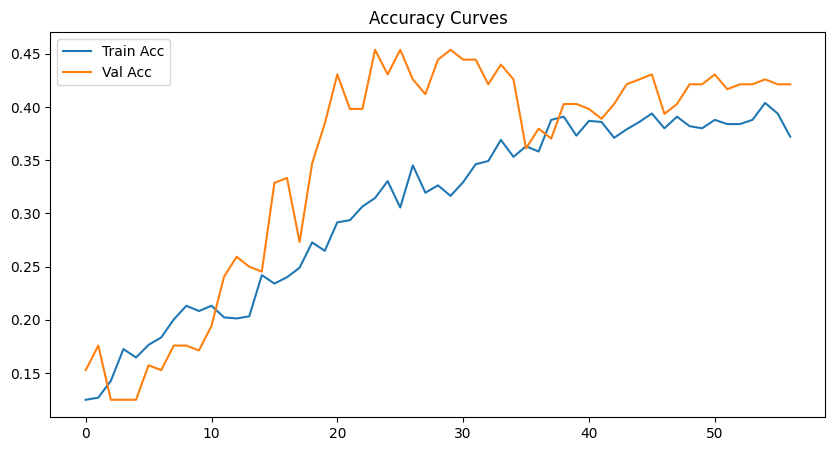

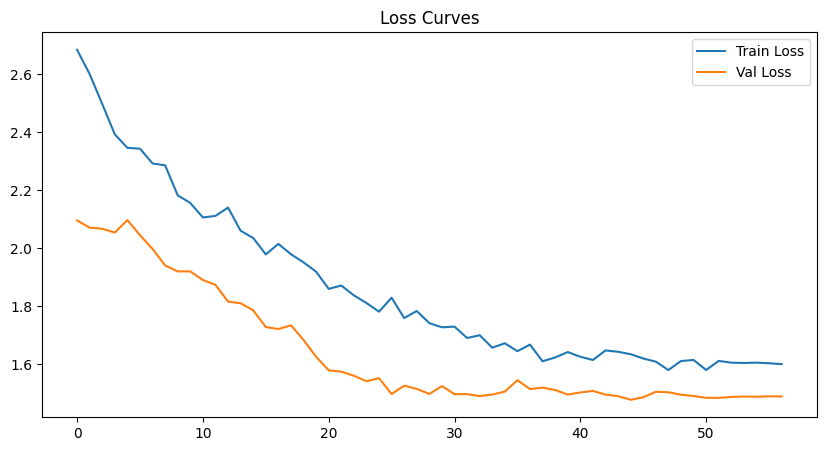

In [59]:
# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curves")
plt.savefig(f"{run_dir}/accuracy_curve.png")
plt.show()

# Loss
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curves")
plt.savefig(f"{run_dir}/loss_curve.png")
plt.show()


In [60]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

with open(f"{run_dir}/evaluation.txt", "w") as f:
    f.write(f"Test Accuracy: {test_acc:.4f}\n")

7/7 [==============================] - 0s 46ms/step - loss: 1.5247 - accuracy: 0.4213
Test Accuracy: 0.4213


In [61]:
save_model(model, f"{run_dir}/final_model.h5")
print("Saved final model.")

Saved final model.


/var/folders/t9/t2k6md8n7c37wyzy4gjgs1640000gn/T/ipykernel_78253/2632278432.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, f"{run_dir}/final_model.h5")


In [66]:
import numpy as np
import json

# Load training data to recompute true statistics
X = np.load("data/X.npy")  # adjust path if needed

mean = float(X.mean())
std  = float(X.std())

stats = {
    "mean": mean,
    "std": std
}

with open("models/run_2025-12-07_03-06-47/mean_std.json", "w") as f:
    json.dump(stats, f)

print("Saved normalization stats.")
print("mean:", mean)
print("std:", std)

Saved normalization stats.
mean: 4.3763881762970414e-07
std: 0.9999986886978149


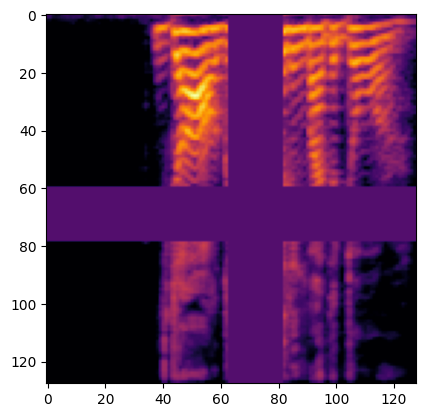

In [62]:
import matplotlib.pyplot as plt

augmented = spec_augment_fn(X_train[0])
plt.imshow(augmented.numpy().squeeze(), cmap='inferno')
plt.show()

In [63]:
import numpy as np

print("Train label distribution:", np.sum(y_train, axis=0))
print("Val label distribution:", np.sum(y_val, axis=0))
print("Test label distribution:", np.sum(y_test, axis=0))


Train label distribution: [ 67. 135. 131. 139. 130. 137. 136. 133.]
Val label distribution: [13. 22. 33. 29. 37. 27. 20. 35.]
Test label distribution: [16. 35. 28. 24. 25. 28. 36. 24.]


In [64]:
preds = model.predict(X_val[:20])
print("Predicted classes:", np.argmax(preds, axis=1))


1/1 [==============================] - 0s 375ms/step
Predicted classes: [6 7 0 5 5 1 5 7 6 4 5 5 5 7 2 5 7 7 5 5]


In [65]:
print("Train example max/min:", X_train[0].max(), X_train[0].min())
print("Val example max/min:", X_val[0].max(), X_val[0].min())
print("Test example max/min:", X_test[0].max(), X_test[0].min())


Train example max/min: 3.175138 -1.0326787
Val example max/min: 3.175138 -1.0326787
Test example max/min: 3.175138 -1.0326787
